In [2]:
# Import required libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [10]:
# Configuration
DATASET_PATH = "data"  # Update this path
CLASSES = ["abnormal", "artifact", "normal"]
SAMPLE_RATE = 22050
DURATION = 10  # seconds
N_MFCC = 52

In [6]:
def load_data(dataset_path):
    """Load audio files and extract features"""
    features = []
    labels = []
    
    for label_idx, class_name in enumerate(CLASSES):
        class_path = os.path.join(dataset_path, class_name)
        
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            
            # Process audio file
            mfccs, _, _ = process_audio(file_path)
            
            features.append(mfccs)
            labels.append(class_name)
    
    return np.array(features), np.array(labels)

In [8]:
def process_audio(file_path):
    """Audio processing pipeline"""
    input_length = SAMPLE_RATE * DURATION
    
    # Load audio
    X, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    
    # Pad if too short
    if len(X) < input_length:
        pad_width = input_length - len(X)
        X = np.pad(X, (0, pad_width), mode='constant')
    
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=X, sr=sr, n_mfcc=N_MFCC,
                                 n_fft=512, hop_length=256)
    mfccs = np.mean(mfccs.T, axis=0)  # Temporal averaging
    
    return mfccs, X, sr

In [12]:
# Load and preprocess data
print("Loading data...")
X, y = load_data(DATASET_PATH)

Loading data...


C:\Users\Lakindu\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Lakindu\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Lakindu\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [15]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [17]:
# Reshape features for CNN
X_reshaped = X.reshape(-1, N_MFCC, 1)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_categorical, test_size=0.2, stratify=y, random_state=42
)

### 2. Model Architecture

In [19]:
def residual_block(x, filters, kernel_size=3):
    """Residual block with skip connection"""
    shortcut = x
    
    # Main path
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Shortcut path
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
        
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

def build_resnet1d(input_shape=(52, 1), num_classes=3):
    """Build ResNet-1D model"""
    inputs = layers.Input(shape=input_shape)
    
    # Initial layers
    x = layers.Conv1D(64, 7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(3, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 128)
    x = residual_block(x, 256)
    
    # Final layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

In [21]:
# Create and compile model
model = build_resnet1d()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 52, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 52, 64)            │             512 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 52, 64)            │             256 │ conv1d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 52, 64)            │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 18, 64)            │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 18, 64)            │          12,352 │ max_pooling1d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 18, 64)            │             256 │ conv1d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 18, 64)            │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 18, 64)            │          12,352 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 18, 64)            │             256 │ conv1d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 18, 64)            │               0 │ max_pooling1d[0][0],       │
│                               │                           │                 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 18, 64)            │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 18, 128)           │          24,704 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 18, 128)           │             512 │ conv1d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 18, 128)           │               

 Total params: 474,627 (1.81 MB)

 Trainable params: 471,939 (1.80 MB)

 Non-trainable params: 2,688 (10.50 KB)

### 3. Training

In [38]:
# Training parameters
EPOCHS = 50
BATCH_SIZE = 32

In [40]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
]

In [42]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8055 - loss: 0.4317

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8033 - loss: 0.4339 - val_accuracy: 0.6533 - val_loss: 0.7425
Epoch 2/50
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7805 - loss: 0.4444

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7812 - loss: 0.4434 - val_accuracy: 0.7956 - val_loss: 0.4410
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7839 - loss: 0.4146 - val_accuracy: 0.6511 - val_loss: 0.5663
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7772 - loss: 0.4541 - val_accuracy: 0.7733 - val_loss: 0.6367
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7744 - loss: 0.4461 - val_accuracy: 0.6044 - val_loss: 0.7106
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7575 - loss: 0.4513 - val_accuracy: 0.6067 - val_loss: 0.6537
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8103 - loss: 0.4056 - val_accuracy: 0.7267 - val_loss: 0.6164


### 4. Evaluation

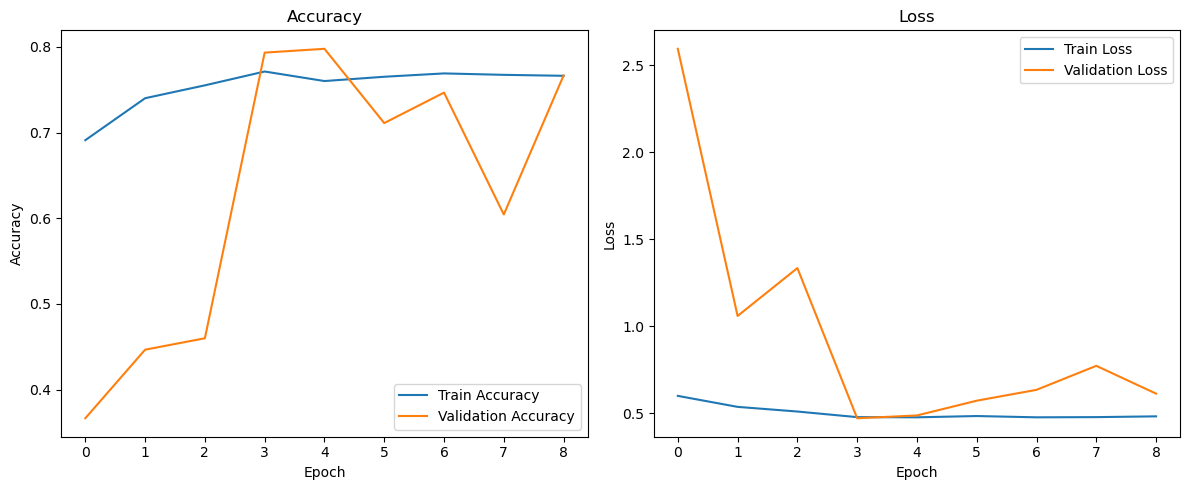

In [34]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")


Test Accuracy: 79.33%
Test Loss: 0.4713


### 5. Save Model

In [ ]:
# Save final model
model.save("heart_sound_resnet.h5")
print("Model saved successfully!")